In [54]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

## Import preprocessed data

In [78]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [79]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x1_Widow,x2_M,x3_1.0,x4_Kind of OK,x4_Meh...,x4_OK nice!,x4_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [80]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [81]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

In [82]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

# Density Based Clustering
## Mean Shift Clustering
What is Mean-shift clustering? How does it work?

Single seed             |  Multiple seeds
:-------------------------:|:-------------------------:
![](../figures/mean_shift_0.gif)  |  ![](../figures/mean_shift_tutorial.gif)
 
### Characteristics:
- No need to define number of clusters apriori

- Can detect clusters of any shape

- Robust to outliers 
    - only take the neighbors into account
    - if outliers exist, no problem because it will not be closer to the other points
    
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
    - dependes also on the amount of data we have

- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth)

In [99]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df[metric_features], quantile=0.06, n_jobs=-1)
bandwidth


#    quantile=0.3, --> reduce this to have more than one clusters
#    n_samples=None,
#    random_state=0,  --> no need if you use all our data
#    n_jobs=None, --> -1 uses all resources of computer (runs faster)


# Radius: 
# Too large --> will converge to the center of the entire data
# Too Small --> it will focus on really small clusters

2.3203034936185496

In [106]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)

ms_labels = ms.fit_predict(df[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters: %d" % ms_n_clusters)

Number of estimated clusters: 4


In [101]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head(10)

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,ms_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0
5,-1.767223,-0.548681,0.424593,-0.181921,-0.653437,1.534436,-0.664445,-0.764540,1.339671,-0.835614,0
6,-0.038516,-0.182305,0.690399,0.862322,0.030517,-1.244465,-0.809480,0.163892,0.203383,-0.116736,0
7,-0.070926,-1.373027,-0.273146,1.427954,-0.790228,-1.323863,-0.664445,-0.897173,-0.283598,-0.968201,0
8,1.430144,0.916823,0.756850,-0.573513,0.304098,0.502272,0.350802,0.296525,-1.365777,0.354704,0
9,0.989443,0.000883,1.354913,-0.617023,1.261634,0.343478,0.350802,-0.234007,-1.473995,-0.369453,0


In [102]:
df_concat.ms_labels.value_counts()

0    7418
1     641
2     393
3     365
Name: ms_labels, dtype: int64

In [103]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares

ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2097


## DBSCAN (Density-based spatial clustering of applications with noise)
What is DBSCAN clustering? How does it work?

DBSCAN animation            |  Core, border and noise
:-------------------------:|:-------------------------:
![](../figures/dbscan.gif)  |  ![](../figures/dbscan.jpg)


### Characteristics:
- No need to define number of clusters apriori
- Resistant to noise and outliers
    - recognizes outliers and leaves them away from the other points
- Can identify outliers
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

In [126]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=-1)
#    eps=0.5,
#    *,
#    min_samples=5, --> The number of samples for a point to be considered as a core point 
#                        (includes the point itself)
#    metric='euclidean',
#    metric_params=None,
#    algorithm='auto',
#    leaf_size=30,
#    p=None,
    
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters: %d" % dbscan_n_clusters)

Number of estimated clusters: 2


### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. **The assumption is that for points in a cluster, their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance

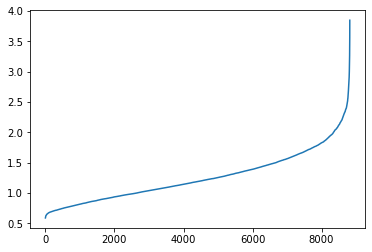

In [127]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[metric_features])

distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.show()

# y axis is the distance

In [128]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [129]:
df_concat.dbscan_labels.value_counts()

# Only one cluster, but outliers are treated as -1

 0    8715
-1     102
Name: dbscan_labels, dtype: int64

In [131]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
15,1.550018,2.199138,0.657173,-1.400205,-0.790228,0.502272,1.075978,3.214455,-1.041124,1.723881,-1
18,0.705467,-0.640275,-0.273146,-1.704776,-0.379855,-1.165068,3.976684,3.877621,-1.473995,-0.707594,-1
77,-0.409958,0.733635,1.255236,-1.226165,-0.653437,1.852024,2.381296,-0.897173,1.339671,2.022158,-1
154,-1.363078,-1.189839,1.554267,-1.791796,1.261634,-1.403260,1.656119,5.071320,-0.067162,-0.985227,-1
186,1.063291,-0.457087,1.521041,-1.313185,0.988052,-0.926877,1.221014,3.479722,0.095165,-0.175941,-1
...,...,...,...,...,...,...,...,...,...,...,...
8393,-0.014182,0.550447,1.487816,-1.487225,0.988052,1.296244,2.236260,-0.631907,0.960908,1.493886,-1
8487,1.072283,1.924356,1.354913,-1.574246,-0.653437,-0.053508,2.381296,3.347089,-1.149342,1.332468,-1
8591,0.294533,-1.464620,-0.339598,-1.530736,-0.516646,0.343478,2.816402,2.153390,-1.149342,-0.975972,-1
8803,0.687849,0.550447,-1.568948,-1.400205,4.407821,-0.291699,-0.519409,0.959691,-1.311668,0.033114,-1


In [133]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]

sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst

print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0339


- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

## GMM (Gaussian Mixture Model )
What is GMM? How does it work?
![](../figures/gmm.gif)

--- 

$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### Characteristics:
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori

In [150]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, 
                      init_params='kmeans', random_state=1)

#    n_components=1,   --> number of clusters (defined a priori)
#    covariance_type='full',
#    tol=0.001,
#    reg_covar=1e-06,
#    max_iter=100,
#    n_init=1,
#    init_params='kmeans',
#    weights_init=None,
#    means_init=None,
#    precisions_init=None,
#    warm_start=False,
#    verbose=0,
#    verbose_interval=10,
    
gmm_labels = gmm.fit_predict(df[metric_features])
print(gmm_labels.shape)

(8817,)


In [151]:
labels_proba = gmm.predict_proba(df[metric_features])
print(labels_proba.shape)

(8817, 4)


**Let's look at the estimated parameters:**

In [152]:
# The estimated component weights
gmm.weights_

array([0.22324086, 0.33573405, 0.25046264, 0.19056245])

In [153]:
# The estimated mean vectors of the Components
print(gmm.means_.shape)
gmm.means_

(4, 10)


array([[-1.10304781, -0.91550901,  0.10629403, -1.04234973,  0.9316929 ,
         0.29434537,  0.91534146,  0.9465233 ,  0.68134282, -0.83563577],
       [ 0.97539549,  0.94396949, -0.05327009, -0.28611798,  0.1233094 ,
         0.33348291,  0.12544242,  0.08199964, -1.06946684,  0.49884501],
       [-0.4850654 , -0.66637609,  0.02202334,  0.36384347, -0.42962485,
         0.05529744, -0.40914011, -0.40667166,  0.56166947, -0.52007653],
       [ 0.21128311,  0.28525367, -0.05961622,  1.24696862, -0.74404013,
        -1.0050323 , -0.75556642, -0.71880209,  0.34778967,  0.78361992]])

In [154]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

# In each component (4), we have a 10x10 matrix

(4, 10, 10)

### Defining covariance_type:
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

![](../figures/gmm_covariance.png)

- `covariance_type="tied"` makes all components share the same general covariance matrix

### Defining n_components:

**AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

**BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

In [155]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

for model in models:
    print(model)

GaussianMixture(n_init=10, random_state=1)
GaussianMixture(n_components=2, n_init=10, random_state=1)
GaussianMixture(n_components=3, n_init=10, random_state=1)
GaussianMixture(n_components=4, n_init=10, random_state=1)
GaussianMixture(n_components=5, n_init=10, random_state=1)
GaussianMixture(n_components=6, n_init=10, random_state=1)
GaussianMixture(n_components=7, n_init=10, random_state=1)
GaussianMixture(n_components=8, n_init=10, random_state=1)
GaussianMixture(n_components=9, n_init=10, random_state=1)
GaussianMixture(n_components=10, n_init=10, random_state=1)
GaussianMixture(n_components=11, n_init=10, random_state=1)
GaussianMixture(n_components=12, n_init=10, random_state=1)
GaussianMixture(n_components=13, n_init=10, random_state=1)
GaussianMixture(n_components=14, n_init=10, random_state=1)
GaussianMixture(n_components=15, n_init=10, random_state=1)


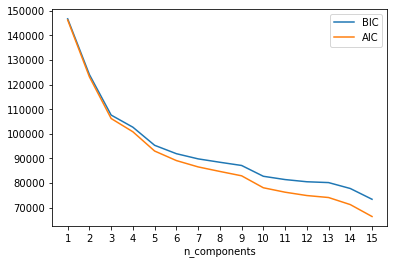

In [156]:
bic_values = [m.bic(df[metric_features]) for m in models]
aic_values = [m.aic(df[metric_features]) for m in models]

plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

# Define the elbow (3??)

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

In [21]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, 
                      init_params='kmeans', random_state=1)

gmm_labels = gmm.fit_predict(df[metric_features])

In [160]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,gmm_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,1
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,1
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,1
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,1


In [161]:
df_concat.gmm_labels.value_counts()

1    2951
2    2231
0    1955
3    1680
Name: gmm_labels, dtype: int64

In [162]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst

print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4241


# Clustering by Perspectives
- Demographic Perspective:
- Value Perspective:
- Product Perspective:

## Merging the Perspectives
- How can we merge different cluster solutions?